In [1]:
# ridge svd?
#wanna go QR _or_ cholesky or what its called? check monday
#expand a bit to allow looping over noise weights?
#first mse r2 for low N?
#Most kFold versions look similar. introduce a "method" parameter and consolidate
#bias also increases with model complexity?

#validation set too?
#CENTER DATA?
#program likes cubic input, fix
# Ridge, 0 lambda best?
#VARIANCES SAME?!?!?!!?

#split in 3, train test to find poly degree, then use thiese betas with validation set to adjust hyperparameters?

In [2]:
#import packages
import numpy as np
from imageio import imread
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Function definitions

In [3]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [4]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [5]:
def ols_svd(X: np.ndarray, z: np.ndarray,_lambda) -> np.ndarray:
    u, s, v = scl.svd(X)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z
# THIS ALGO NEEDS IMPROVEMENT! QR decomp

In [6]:
def ols_inv(X: np.ndarray, z: np.ndarray) -> np.ndarray:
    return scl.inv(X.T @ X) @ (X.T @ z)

In [7]:
"""
Just a standard R2 score calculator, taking the measured/real data as the first input, and the values the 
regression model finds as the second input
"""
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [8]:
"""
Standard mean squared error calculator, inputs are measured/real data and regression model values.
"""
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [39]:
def VarOLS(y_data, y_model,X):
    N = len(y_data)
    covar = np.linalg.inv(X.T.dot(X))#sigma2, should be noiseweight squared
    vari = np.diagonal(covar)
    return vari

In [10]:
def VarRidge(X,_lambda): #sigma2? NoiseWeight squared
    XX = X.T@X
    invers = np.linalg.inv(XX+_lambda*np.eye(len(XX)))
    return np.diagonal(invers)

In [11]:
def NoResampling(X,z_n,_lambda):
#     beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)
#     beta = ols_svd(X,z_n,_lambda)
#     beta = ols_inv(X,z_n)
    ztilde = X @ beta
    return MSE(z_n,ztilde), R2(z_n,ztilde)

In [12]:
def kSplitter(X,z,k):
    k = int(np.math.ceil((1./k)*len(X)))
    n,m = np.shape(X)
    ind = np.arange(0,n,k)
    for i in ind:
        X_test, z_test = X[i:(i+k),:],z[i:(i+k)]
        if i ==0:
            X_train,z_train = X[i+k:,:],z[i+k:]
        elif i ==(n-k):
            X_train,z_train = X[:i,:],z[:i]
        else:
            X_train = np.vstack([X[:i,:],X[i+k:,:]])
            z_train = np.hstack([z[:i],z[i+k:]])
        yield X_train, X_test, z_train, z_test

In [13]:
def Bias(y_data, y_model, P, X):
    N = len(y_data) #should probably insert z here
    return np.sum((y_data-y_model)*(y_data-y_model))/N

In [210]:
def Shuffler(X,z_n):
    np.random.seed(1234)
    n = len(X[0,:])
    combi = np.c_[X,z_n] #combine
    np.random.shuffle(combi) #shuffle
    X, z_n = combi[:,:n], combi[:,n] #split
    return X, z_n

In [187]:
def kFold(k,X,z_n):
    #shuffle data before doing the kFold
    X,z_n = Shuffler(X,z_n)

    #initialize values
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    sVar = 0.
    sMean = 0.
    betas = []
    sM = []
    tilder=[]
    c = 0
    for X_train, X_test, z_train, z_test in kSplitter(X,z_n,k):
        # find parameters
        betas.append(ols_svd(X_train,z_train,0.))
#         beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
    
        # make prediction
        z_tilde =X_test @ betas[c][:]
        c+=1

        #store data per fold
#         sMSE += MSE(z_tilde,z_test)
        sR2 += R2(z_test,z_tilde)
#         sVar += np.var(z_tilde)
#         sMean +=MSE(z_test,np.mean(z_tilde))
        tilder = np.hstack((tilder,z_tilde))
        #Morten store
        sMSE += np.mean((z_test - z_tilde)**2)
#         sM = np.hstack((sM,(z_test - np.mean(z_tilde))**2))
        sVar +=  np.var(z_tilde)
        sMean += np.mean(z_tilde)
#     print("aaa", np.shape(sM))
    smeen = np.mean(z_n - sMean/k)
    mugg = np.mean(tilder)
    hum = np.mean((z_n-mugg)**2)
#         sMean +=np.mean((z_test-np.mean(z_tilde))**2)
    vari = np.var(tilder)
    return sMSE/k, sR2/k, np.mean(betas,axis=0), vari, hum#sVar/k, smeen#np.mean(sM)#,VAR SOMEHOW 

In [16]:
def kFoldskl(k,X,z_n):
    #shuffle data before doing the kFold
    X, z_n = Shuffler(X,z_n)

    #initialize values
    sMSE =0.
    sR2 =0.
    betas=[]
    
    kfold = KFold(k,shuffle=False)   
    for train,test in kfold.split(X,z_n):
        # find parameters
        clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
        clf.fit(X[train],z_n[train]) 
        
        betas.append(clf.coef_)
        
        #make prediction
        z_tilde = clf.predict(X[test])

        #store data per fold
        sMSE += MSE(z_tilde,z_n[test])
        sR2 += R2(z_n[test],z_tilde)

    return sMSE/k,sR2/k,np.mean(betas,axis=0)#,VAR SOMEHOW

In [17]:
def kFoldRidge(k,X,z_n,_lambda):
    #shuffle data before doing the kFold
    X,z_n = Shuffler(X,z_n)
    n = len(X[0,:])

    #initialize values
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    betas =[]
    c=0
    for X_train, X_test, z_train, z_test in kSplitter(X,z_n,k):
        #center data for ridge
        X_train = np.delete(X_train-np.mean(X_train,axis=0),0,1)
        X_test = np.delete(X_test-np.mean(X_test,axis=0),0,1)
        z_train = z_train -np.mean(z_train)
        z_test = z_test-np.mean(z_test)
        
        
        # find parameters
        betas.append(np.linalg.inv(X_train.T.dot(X_train)+_lambda*np.eye(n-1)).dot(X_train.T).dot(z_train))
        
        # make prediction
        z_tilde = X_test @ betas[c][:]
        c+=1
        
        sMSE += MSE(z_tilde,z_test)
        sR2 += R2(z_test,z_tilde)
    
    return sMSE/k,sR2/k,np.mean(betas,axis=0)#,VAR SOMEHOW

In [18]:
def kFoldLassoCV(k,X,z_n,_lambda):
    _lambda = [_lambda]
    #How to select good tolerances and max iters?
    reg = skl.LassoCV(alphas=_lambda,cv = k, random_state = 0,tol=0.0001,max_iter = 10000000).fit(X,z_n)
    ztilde = reg.predict(X)
#     plt.figure()
#     plt.semilogx(reg.alphas_,reg.mse_path_)
#     plt.semilogx(reg.alphas_,reg.mse_path_.mean(axis=-1),'k')
#     plt.xlabel('Log-plot of lambdas')
#     plt.ylabel('Mean squared error')
#     plt.show()
  
    return np.mean(reg.mse_path_) , r2_score(z_n,ztilde), reg.coef_

In [19]:
def kFoldLasso(k,X,z_n,_lambda):
    # this converges slowly for small lambda!
    
    #shuffle data before doing the kFold
    n = len(X[0,:])
    X,z_n = Shuffler(X,z_n)


    #initialize values
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    betas = []
    
    for X_train, X_test, z_train, z_test in kSplitter(X,z_n,k):
        # find parameters
        lass = skl.Lasso(alpha=_lambda,tol = 0.0001,max_iter=100000)
        lass.fit(X_train,z_train)
    
        #make prediction
        z_tilde = lass.predict(X_test)
        betas.append(lass.coef_)
        
        sMSE+= MSE(z_tilde,z_n)
        sR2 += R2(z_n,z_tilde)
    
    return sMSE/k,R2/k,np.mean(betas,axis=0)

# Initiate variables!

In [211]:
#Create random variables/predictors
np.random.seed(1234)
N = 20 #number of points along x and y axes

# sort this for meshgrid
x = np.random.uniform(0,1,N)
y = np.random.uniform(0,1,N)

x = sorted(x)
y = sorted(y)
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_n = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_n) ##### RAVEL?
z = np.matrix.flatten(z)

#number of folds for crossvalidation
k=5

# Do stuff with the code!

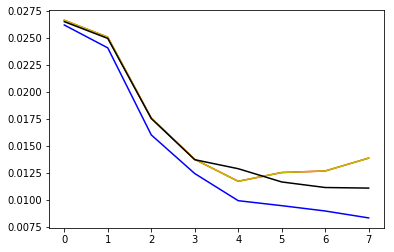

<Figure size 432x288 with 0 Axes>

In [212]:
maxpd = 8
_lam = 0.0001
No_resampling = []
kfold_resampling = []
kfold_resampling_skl = []
kfold_ridge = []
kfold_lasso = []

for i in range(maxpd):
    X = Model(x,y,i+1)
    No_resampling.append(NoResampling(X,z_n,_lam)[0])
    kfold_resampling.append(kFold(k,X,z_n)[0])
    kfold_resampling_skl.append(kFoldskl(k,X,z_n)[0])
    kfold_ridge.append(kFoldRidge(k,X,z_n,_lam)[0])
#     kfold_lasso.append(kFoldLassoCV(k,X,z_n,0.000001)[0])
plt.figure()
plt.plot(No_resampling,'b')
plt.plot(kfold_resampling,'r')
plt.plot(kfold_resampling_skl,'y')
plt.plot(kfold_ridge,'k')
# plt.plot(kfold_lasso,'c')
plt.figure()
plt.show()

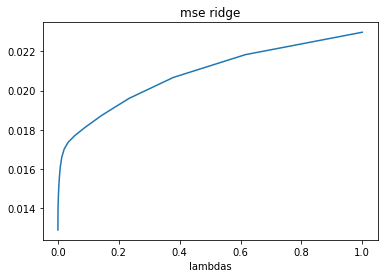

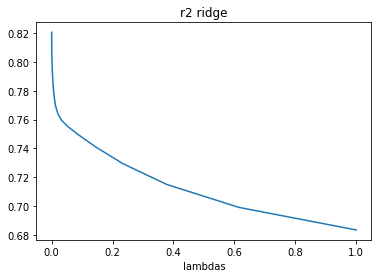

In [213]:
pd = 5

_lams = np.logspace(-4,0,20)
# _lams = np.linspace(1e-4,1.,20)

X = Model(x,y,pd)
fish=[]
rish=[]

for i in _lams:
    fish.append(kFoldRidge(k,X,z_n,i)[0])
    rish.append(kFoldRidge(k,X,z_n,i)[1])
plt.figure()
plt.plot(_lams,fish)
plt.title("mse ridge")
plt.xlabel("lambdas")
plt.show()
plt.figure()
plt.plot(_lams,rish)
plt.title("r2 ridge")
plt.xlabel("lambdas")

plt.show()

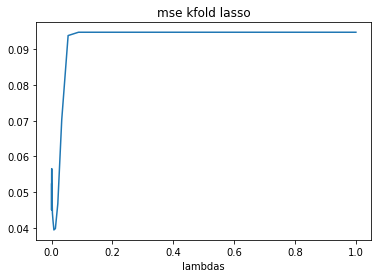

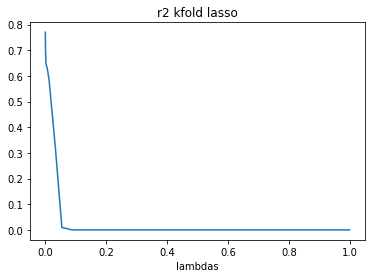

In [214]:
X_c = np.delete(X-np.mean(X,axis=0),0,1)
z_n_c = z_n -np.mean(z_n)

X = Model(x,y,pd)
fish=[]
rish=[]

for i in _lams:
    fish.append(kFoldLassoCV(k,X,z_n,i)[0])
    rish.append(kFoldLassoCV(k,X,z_n,i)[1])
plt.figure()
plt.plot(_lams,fish)
plt.title("mse kfold lasso")
plt.xlabel("lambdas")

plt.show()
plt.figure()
plt.plot(_lams,rish)
plt.title("r2 kfold lasso")
plt.xlabel("lambdas")

plt.show()

# b

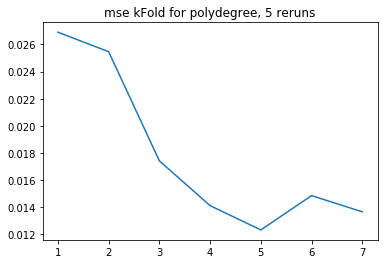

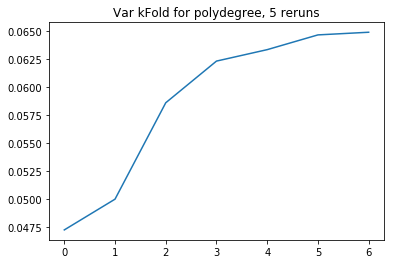

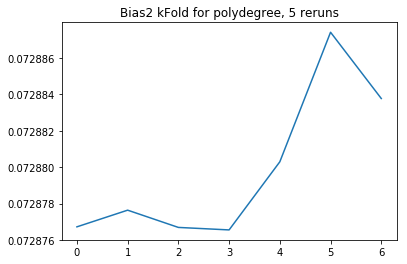

In [215]:
NN = 5
mpd = 7
ms = []
rs = []
vs = []
bs = []

for i in range(mpd):
    X = Model(x,y,i+1)
    Xn,z_nn=Shuffler(X,z_n)
    msi=0
    rsi = 0
    vsi = 0
    bsi = 0
    
    for l in range(NN):
        msi += kFold(k,Xn,z_nn)[0]
        rsi += kFold(k,Xn,z_nn)[1]
        vsi += kFold(k,Xn,z_nn)[3]
        bsi += kFold(k,Xn,z_nn)[4]
    ms.append(msi/NN)
    rs.append(rsi/NN)
    vs.append(vsi/NN)
    bs.append(bsi/NN)
    
plt.figure()
plt.plot(np.arange(mpd)+1,ms)
plt.title("mse kFold for polydegree, 5 reruns")
plt.show()

plt.figure()
plt.plot(vs)
plt.title("Var kFold for polydegree, 5 reruns")
plt.show()

plt.figure()
plt.plot(bs)
plt.title("Bias2 kFold for polydegree, 5 reruns")
plt.show()


# plt.figure()
# plt.plot(np.arange(mpd)+1,rs)
# plt.title("r2 kFold for polydegree, 5 reruns")
# plt.show()

# print(np.shape(bs),np.shape(vs))
# plt.figure()
# # plt.plot(np.arange(mpd)+1,ms)
# # plt.plot(np.arange(mpd)+1,ms)
# bst = [i /90 for i in bs]
# plt.plot(bst)
# plt.plot(vs)
# plt.show()

In [26]:
#Run NN kFolds to create bias/variance plot
#My bias increases again with model complexity
NN=5
mpd = 15
qq = len(z_n)

#sort noisy signal
z_n_sorted = sorted(z_n)

#initialize variables 
NMSE_k = np.zeros(shape=(NN,mpd)) #MSE stored for each run of kFold
model_values = np.zeros(shape=(NN,mpd,qq))
bias2 = np.zeros(mpd)
var = np.zeros(mpd)
bias2_ = np.zeros(shape=(mpd,qq))
var_ = np.zeros(shape=(mpd,qq))

# betas = np.zeros(shape=(NN,mpd))
betas=[]
#Run NN kFolds
for l in range(NN):
    #shuffle here
    for i in range(mpd):
        X = Model(x,y,i+1)
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
        model_values[l,i] = kFold(k,X,z_n)[0]
        NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
        if l == 0:
            betas.append(kFold(k,X,z_n)[1])
NMSE = np.mean(NMSE_k,axis=0)

#Calculate bias and variance for each polynomial degree
for i in range(mpd):
    for m in range(qq):
        bias2_[i,m] = np.mean(model_values[:,i,m])
        var_[i,m] = np.var(model_values[:,i,m])
    bias2[i]=np.mean((z_n_sorted-bias2_[i])**2)
    var[i] = np.mean(var_[i])

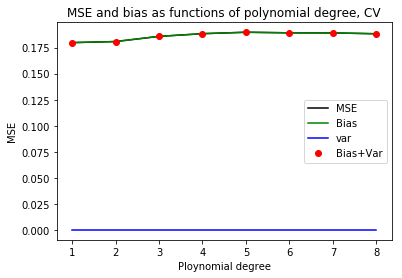

In [27]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 8
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bias2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),var[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bias2[:maxi]+var[:maxi],'ro')
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
xp = np.arange(0,1,0.05)
yp = np.arange(0,1,0.05)
xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
fz = FrankeFunction(xp,yp)
for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xz,yz,i+1)
    zp = Xp@betas[i]
    zp.shape=(20,20)
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
#     axs.plot_surface(xp,yp,fz,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
    axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
xp = np.arange(0,1,0.05)
yp = np.arange(0,1,0.05)
xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
fz = FrankeFunction(xp,yp)
for i in range(pd):
    axs = fig.add_subplot(3,3,i+1)
    Xp = Model(xz,yz,i+1)
    zp = Xp@betas[i]
    zp.shape=(20,20)
#     plo = zp-fz
    plo = np.subtract(zp,fz)
#     print("a",zp[0],"b",fz[0],"c",plo[0])
    aa = axs.contourf(plo,cmap=cm.coolwarm)
#     axs.plot(plo[0],plo[1])
#     axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
#     axs.addaxes(xp)
#     axs.set_zlabel('z')
#     axs.set_title('Polynomial degree = {}'.format(i+1))
#     axs.set_zlim(-0.10,1.40)
#     axs.zaxis.set_major_locator(LinearLocator(10))
#     axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(aa,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [ ]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 9
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bias2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),var[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bias2[:maxi]+var[:maxi],'ro')
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

In [ ]:
maxpd = 5
for i in range(maxpd):
    print("Polynomial degree", i+1)
    X = Model(x,y,i+1)
#     X = X-np.mean(X,axis=0)
#     X[:,0]=1.
#     z_n = z_n -np.mean(z_n)
    ztilde = kFold(k,X,z_n)[0]
    print("OLS")
    print("beta",kFold(k,X,z_n)[1])
    print("pm",1.96*np.sqrt(abs(VarOLS(z_n, ztilde, i,X))))
    print("variance",VarOLS(z_n,ztilde,i,X))
    ztilde = kFoldRidge(k,X,z_n,100.1)[0] #just a random lambda value
    print("Ridge")
    print("beta",kFoldRidge(k,X,z_n,0.1)[1])
    print("pm",1.96*np.sqrt(abs(VarOLS(z_n, ztilde, i,X))))
#     print("variance",VarOLS(z_n,ztilde,i,X))
    print("variance",VarRidge(X,10000.1))
    ztilde = kFoldLassoCV(k,X,z_n,[100.001,100.01])
    print("Lasso")
    print("beta",kFold(k,X,z_n)[1])
    print("pm",1.96*np.sqrt(abs(VarOLS(z_n, ztilde, i,X))))
    print("variance",VarOLS(z_n,ztilde,i,X))
    print("-------------------")
    ### ALL VARIANCES ARE THE SAME, WHY?!?!

# c

In [ ]:
_lams = np.logspace(-4,0,10)
kFoldLassoCV(k,X,z_n,_lams)

In [ ]:
MPD = np.arange(9)+1#np.arange(9)+1
MSE_degree = []


#shuffle data before doing the kFold
# n = len(X[0,:])
# combi = np.c_[X,z_n]
# np.random.shuffle(combi)
# X, z_n = combi[:,:n], combi[:,n]
# X_new,z_n_new = Shuffler(X,z_n)
for i in MPD:
    X = Model(x,y,i)
    
    z_out = kFold(k,X,z_n)
#     dMSE, dR2 = NoResampling(X,z_n,0)
#     dMSE,dR2 = kFoldskl(k,X,z_n)
#     print(i,dMSE)
    MSE_degree.append(MSE(z_out,z_n_sorted))
# MS = MSE(MSE_degree,z_n)

In [ ]:
plt.figure()
plt.plot(MPD+1,MSE_degree)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.show()

# d

In [ ]:
_lambda = np.logspace(-4,5,10)

RidgeMSE = np.zeros((len(MPD),len(_lambda)))
RidgeR2 = np.zeros((len(MPD),len(_lambda)))



for i,mpd in enumerate(MPD):
    X = Model(x,y,mpd)
    for j,lam in enumerate(_lambda):
#         rMSE,rR2 = NoResampling(X,z_n,lam)
        z_out = kFoldRidge(k,X,z_n,lam)
        RidgeMSE[i][j] = MSE(z_out,z_n_sorted)
        RidgeR2[i][j] = R2(z_n_sorted,z_out)

In [ ]:
plt.figure()

for i in range(len(_lambda)):
    plt.semilogy(MPD,RidgeMSE[:,i],label=_lambda[i])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
plt.figure()

for i in range(len(MPD)):
    plt.loglog(_lambda,RidgeMSE[i,:],label=i+1)
plt.xlabel('lambda')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# e

In [ ]:
# I'll use Scikit-learn as recommended for this
kFoldLassoCV(k,X,z_n,_lambda)


In [ ]:
terrain = imread('SRTM_data_Norway_1.tif')
terr_square = terrain[0:100,0:100]
print(np.shape(terr_square))

In [ ]:
terra = np.matrix.flatten(terr_square)
print(np.shape(terra))
# x = np.linspace(0,len(terr_square[0]),100)
# y = np.linspace(0,len(terr_square[1]),100)
x = np.linspace(0,1,np.sqrt(len(terra)))
y=np.linspace(0,1,np.sqrt(len(terra)))
x, y = np.meshgrid(x,y,sparse=False)


In [ ]:
X = Model(x,y,5)


X_c = X-np.mean(X,axis=0)
X_c[:,0]=1.
terra_c = terra -np.mean(terra)

In [ ]:
NoResampling(X,terra,0.)

In [ ]:
betas=[]
mpd = 6
for i in range(mpd):
        X = Model(xp,yp,i+1)
        print(np.shape(X))
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
#         model_values[l,i] = kFold(k,X,z_n)[0]
#         NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
#         if l == 0:
        betas.append(kFold(k,X,terra)[1])

In [ ]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
# xp = np.arange(0,1,0.05)
# yp = np.arange(0,1,0.05)


xp = np.linspace(0,1,len(terr_square[0]))
yp=np.linspace(0,1,len(terr_square[1]))

xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
# fz = FrankeFunction(xp,yp)


betas=[]
for i in range(pd):
        X = Model(xp,yp,i+1)
        betas.append(kFold(k,X,terra)[1])

for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xp,yp,i+1)
    zp = Xp@betas[i]
    zp.shape=(len(xp),len(yp))
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
#     axs.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
#     axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [ ]:
fig2 = plt.figure()
axers = fig2.gca(projection='3d')

for i in range(pd):
    surf = axers.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
plt.show()

In [ ]:
pd = 5
_lams = np.linspace(0.0,1.,10)
X = Model(x,y,pd)
fish=[]
for i in range(len(_lams)):
    fish.append(kFoldRidge(k,X,z_n,i))